In [1]:
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

import re
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('stopwords',quiet=True)
nltk.download('punkt',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('omw-1.4',quiet=True)
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import  LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

KeyboardInterrupt: 

In [2]:
default_stemmer = PorterStemmer()
default_stopwords = stopwords.words('english')
default_stopwords = default_stopwords + ['said', 'would','even','according','could','year',
                                         'years','also','new','people','old,''one','two','time',
                                         'first','last','say','make','best','get','three','make',
                                         'year old','told','made','like','take','many','set','number',
                                         'month','week','well','back']
shortword = re.compile(r'\W*\b\w{1,4}\b\d')
BAD_SYMBOLS_RE = re.compile("[^a-zA-Z,\d]")
REPLACE_IP_ADDRESS = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
def clean_text(text, ):

    def tokenize_text(text):
        return [w for s in sent_tokenize(text) for w in word_tokenize(s) if len(w)>=3]

    def preprocessing_text(text):
        text = text.lower()
        text=text.replace('\n',' ').replace('\xa0',' ').replace('-',' ').replace('ó','o').replace('ğ','g').replace('á','a').replace("'"," ")
        text=re.sub(r'\d+','', text)
        text=re.sub(r'http\S+', '', text)
        text=BAD_SYMBOLS_RE.sub(' ', text)
        text=REPLACE_IP_ADDRESS.sub('', text)
        text=REPLACE_BY_SPACE_RE.sub(' ', text)
        text=' '.join(word for word in text.split() if len(word)>3)
        
        return text

    def remove_special_characters(text, characters=string.punctuation.replace('-', '')):
        tokens = tokenize_text(text)
        pattern = re.compile('[{}]'.format(re.escape(characters + '0123456789')))
        return ' '.join(filter(None, [pattern.sub('', t) for t in tokens]))

    def stem_text(text, stemmer=default_stemmer):
        tokens = tokenize_text(text)
        return ' '.join([stemmer.stem(t) for t in tokens])

    def lemm_text(text, lemm=WordNetLemmatizer()):
        tokens = tokenize_text(text)
        return ' '.join([lemm.lemmatize(t) for t in tokens])

    def remove_stopwords(text, stop_words=default_stopwords):
        tokens = [w for w in tokenize_text(text) if w not in stop_words]
        return ' '.join(tokens)
    
    text = text.strip(' ') # strip whitespaces
    text = text.lower() # lowercase
    #text = stem_text(text) # stemming
    text=preprocessing_text(text)
    text = remove_special_characters(text) # remove punctuation and symbols
    text = lemm_text(text) # lemmatizer
    text = remove_stopwords(text) # remove stopwords

    return text

In [3]:
df = pd.read_csv('combined_news_data.csv')
selected_categories = [
    'arts, culture, entertainment and media',
    'economy, business and finance',
    'politics',
    'science and technology',
    'sport'
]
df = df[df['category_level_1'].isin(selected_categories)]
df['text'] = df[['title', 'content']].apply(lambda x: ' . '.join(x.astype(str)), axis=1)
df['text'] = df['text'].apply(clean_text)
y = pd.get_dummies(df['category_level_1'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], y, test_size=0.2, random_state=42,stratify=y)

In [5]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [6]:
param_grid = {
    'estimator__alpha': [0.01, 0.1, 1, 10],
}

model = GridSearchCV(MultiOutputClassifier(MultinomialNB()), 
                     param_grid=param_grid,
                     cv=10,
                     scoring='f1_weighted')

model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

In [ ]:
best_model = model.best_estimator_

ypred = best_model.predict(X_test_tfidf)

print("Best Parameters:", model.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=y.columns))

In [8]:
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.8610
Recall: 0.7964
F1 Score: 0.8263


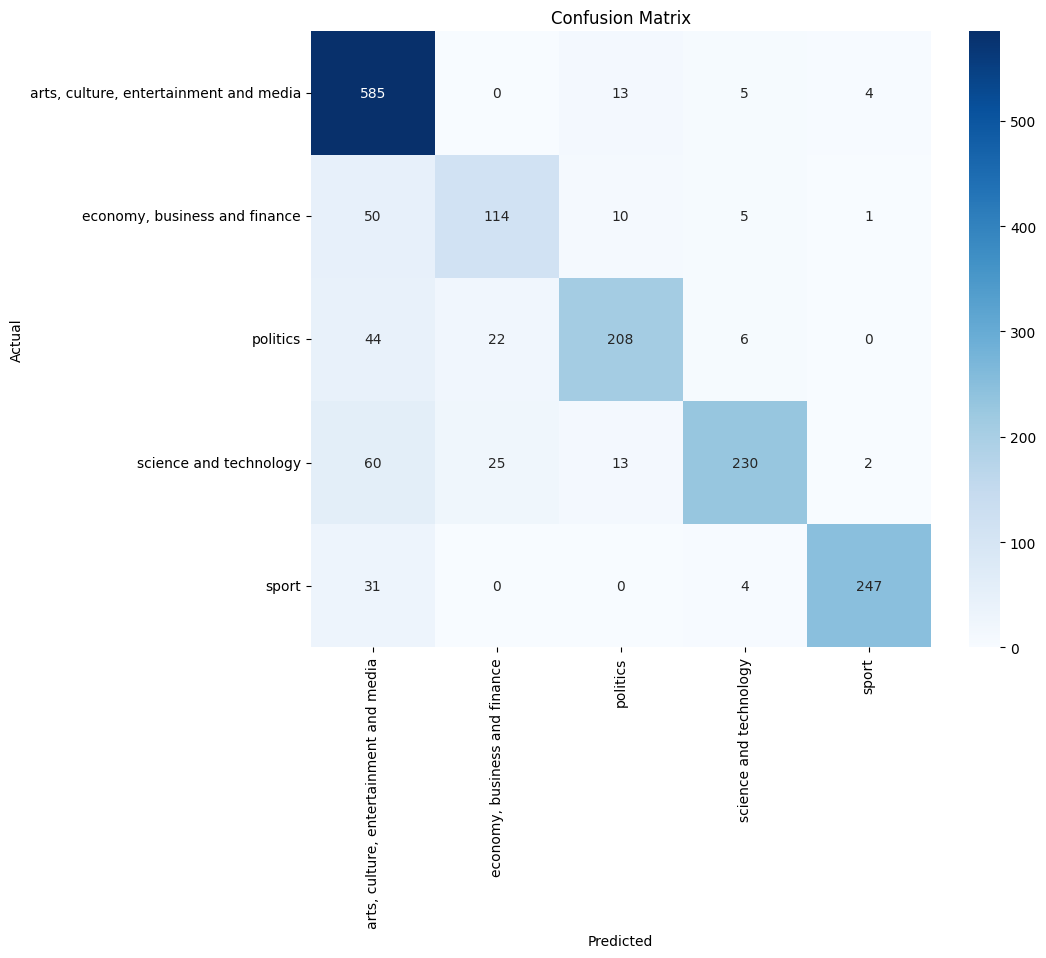

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
conf_mat = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
             xticklabels=y.columns, yticklabels=y.columns)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


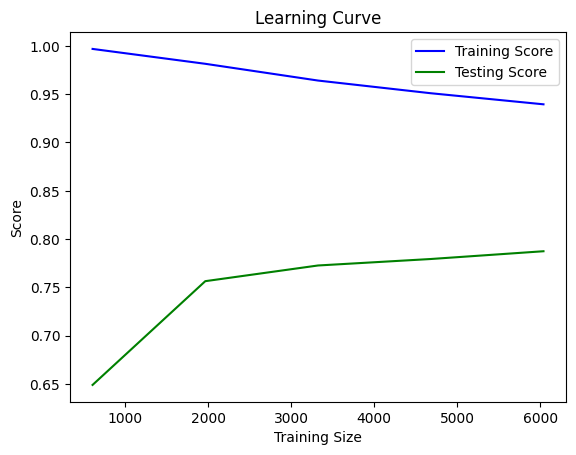

In [10]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model.best_estimator_, X_train_tfidf, y_train, cv=10)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Testing Score', color='green')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend()
plt.show()